In [103]:
# pip install wandb

# Quetion 1

In [104]:
import matplotlib.pyplot as plt
import numpy as np
# import wandb
from keras.datasets import fashion_mnist

In [105]:
# !wandb login 494428cc53b5c21da594f4fc75035d136c63a93c

In [106]:
# wandb.init(project="CS6910 - Assignment 1", name="Question1")

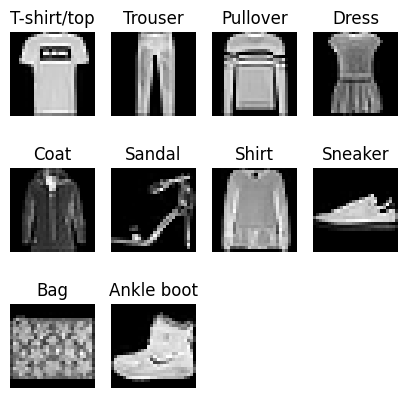

In [107]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Define class names
className_images = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
trainingData_length=len(train_labels)
total_class=max(train_labels)+1

# print(trainingData_length)
# print(y)

#plotting images with its labels
plt.figure(figsize=(5, 5))
for i in range(total_class):
    #subplot - used so that we can have many images in one image
    # 1st row,2nd col, 3rd index of curr
    plt.subplot(3, 4, i + 1)
    sample_array = np.where(train_labels == i)
    label_index=sample_array[0][0]
    plt.imshow(train_images[label_index], cmap='gray')
    plt.title(className_images[i])
    plt.axis('off')
    # wandb.log({"Question1": [wandb.Image(train_images[label_index], caption=className_images[i])]})

plt.show()

In [108]:
# wandb.finish()

# Question 2

In [109]:
# wandb.init(project="CS6910 - Assignment 1", name="Question2")

# MultiLayerPerceptron_Class

In [153]:
class MultiLayerPerceptron():

    def __init__(
          self, 
          train_data, 
          train_labels, 
          layer_sizes,
          initialization,
          act_func,
          loss_func,
          batch_size=4,
          epochs=1,
          learning_rate=0.1,
          weight_decay=0,
          optimizer="sgd",
          momentum=0.5,
          beta=0.5,
          beta1=0.5,
          beta2=0.5,  
          epsilon=0.000001
          ):

        self.parameters = {}
        self.gradients = {}
        self.train_data = train_data
        self.train_labels = train_labels
        self.no_of_samples = len(train_data)
        self.no_of_features = train_data.shape[1] #size of column of train_data
        self.no_of_classes = 10 #size of column of train_labels
        self.layer_sizes = layer_sizes
        self.batch_size=batch_size
        self.act_func=act_func
        self.epochs=epochs
        self.learning_rate=learning_rate
        self.weight_decay=weight_decay
        self.optimizer=optimizer
        self.loss_func=loss_func
        self.initialization = initialization
        self.momentum=momentum
        self.beta=beta
        self.beta1=beta1
        self.beta2=beta2
        self.epsilon=epsilon

        self.A = {}
        self.H = {}       

    def init_weights(self):
      if self.initialization=="random":
        # print("init random")
        for i in range(len(self.layer_sizes) - 1):
            #input layer(n) and 1st hidden layer(m) will have weight vector w1->n*m and bias b1->1*m
            #init W to random values
            self.parameters[f'w_{i+1}'] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
            #init B to 0
            self.parameters[f'b_{i+1}'] = np.random.randn(1,self.layer_sizes[i+1])

      if self.initialization=="Xavier":
        print("inint Xavier")
        for i in range(len(self.layer_sizes) - 1):
          x_fact = np.sqrt(6 / (self.layer_sizes[i] + self.layer_sizes[i + 1]))
          self.parameters[f'w_{i+1}'] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * x_fact
          self.parameters[f'b_{i+1}'] = np.random.randn(1,self.layer_sizes[i+1]) * x_fact

    def softmax(self, x):
      exps = np.exp(x - np.max(x, axis=1, keepdims=True))
      return exps / np.sum(exps, axis=1, keepdims=True)

    def softmax_d(self,x):
      softmax_x = self.softmax(x)
      return softmax_x*(1-softmax_x)

    def feed_forwards(self, input_data):

        # self.H[0]=input_data
        for i in range(len(self.layer_sizes) - 1): # i -> 0-3
            # if(i==0) :#input is our images
            if(i==0):
              self.A[i+1]=np.dot(input_data , self.parameters[f'w_{i+1}']) + self.parameters[f'b_{i+1}']
            else:
              self.A[i+1] = np.dot(self.H[i], self.parameters[f'w_{i+1}']) + self.parameters[f'b_{i+1}']

            if i < len(self.layer_sizes) - 2 : # i < 3
                self.H[i+1] = self.act_func.activation_func(self.A[i+1])
            else :
                self.H[i+1]=self.softmax(self.A[i+1])

        return self.H[len(self.layer_sizes)-1]


    def back_prop(self, input_data, true_label,y_pred):
        # print("in back")
        if ((self.loss_func).get_name()=="cross_entropy"):
          # print("cross_entropy")
          dL_dA = y_pred - true_label
        elif ((self.loss_func).get_name()=="mean_squared_error"):
          dL_dA = ((y_pred - true_label) * self.softmax_d(self.A[len(self.layer_sizes)-1])) / true_label.shape[0]

        for i in range(len(self.layer_sizes) - 1, 1, -1): # i->4 3 2

            self.gradients[f'w_{i}']=np.dot(self.H[i-1].T, dL_dA)
            self.gradients[f'b_{i}']=np.sum(dL_dA , axis=0,keepdims=True)

            dL_dH=np.dot(dL_dA, (self.parameters[f'w_{i}']).T )
            dL_dA = dL_dH * self.act_func.derivation_of_activation(self.A[i-1])

        self.gradients[f'w_{1}']=np.dot(input_data.T, dL_dA )
        self.gradients[f'b_{1}']=np.sum(dL_dA , axis=0,keepdims=True)

    def optimizer_func(self):
        
        if(self.optimizer=="sgd"):
            #this is batch gradient descent or SGD
            # no_of_batches = self.no_of_samples // batch_size
            for i in range(self.epochs):
                for j in range(0,self.no_of_samples,self.batch_size):
                    start = j
                    end = start + self.batch_size
                    Y_train = self.train_labels[start:end]
                    X_train = self.train_data[start:end]

                    y_pred=self.feed_forwards(X_train)
                    # y_pred=self.fprg(X_train)
                    self.back_prop(X_train, Y_train,y_pred)

                    for k in range(4):# 0->3
                        self.gradients[f'w_{k+1}']=self.gradients[f'w_{k+1}']/self.batch_size
                        self.gradients[f'b_{k+1}']=self.gradients[f'b_{k+1}']/self.batch_size

                        self.gradients[f'w_{k+1}'] =(self.gradients[f'w_{k+1}']) + self.weight_decay * self.parameters[f'w_{k+1}']
                        self.parameters[f'w_{k+1}'] -= self.learning_rate * (self.gradients[f'w_{k+1}'] )
                        self.parameters[f'b_{k+1}'] -= self.learning_rate * (self.gradients[f'b_{k+1}'] )

                loss,acc=self.loss_accuracy(self.train_data,self.train_labels)
                print(f"Epoch {i+1}, Loss: {loss} Acc: {acc}")
                # wandb.log({"Epoch {i+1}, Loss: {loss} Acc: {acc}"})

        if(self.optimizer=="momentum"):
          '''
          Epoch 10, Loss: 0.6812374987038496 Acc: 75.0
          TEST LOSS: 0.7075 ACCURACY: 72.0900
          '''
          velocities={}
          for i in range(len(self.layer_sizes) - 1):            
            velocities[f'w_{i+1}'] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))            
            velocities[f'b_{i+1}'] = np.zeros((1, self.layer_sizes[i+1]))

          for i in range(self.epochs):
            for j in range(0,self.no_of_samples,self.batch_size):
              start = j
              end = start + self.batch_size
              Y_train = self.train_labels[start:end]
              X_train = self.train_data[start:end]

              y_pred=self.feed_forwards(X_train)
              self.back_prop(X_train, Y_train,y_pred)
          
              for k in range(len(self.layer_sizes) - 1):
                  self.gradients[f'w_{k+1}']=self.gradients[f'w_{k+1}']/self.batch_size
                  self.gradients[f'b_{k+1}']=self.gradients[f'b_{k+1}']/self.batch_size

                  self.gradients[f'w_{k+1}'] =(self.gradients[f'w_{k+1}']) + self.weight_decay * self.parameters[f'w_{k+1}']
                  # Update velocities with momentum
                  velocities[f'w_{k+1}'] = self.momentum * velocities[f'w_{k+1}'] + self.learning_rate * (self.gradients[f'w_{k+1}'])
                  velocities[f'b_{k+1}'] = self.momentum * velocities[f'b_{k+1}'] + self.learning_rate * (self.gradients[f'b_{k+1}'])

                  # Update parameters with momentum
                  self.parameters[f'w_{k+1}'] -= velocities[f'w_{k+1}']
                  self.parameters[f'b_{k+1}'] -= velocities[f'b_{k+1}']

            loss,acc=self.loss_accuracy(self.train_data,self.train_labels)
            print(f"Epoch {i+1}, Loss: {loss} Acc: {acc}")

        if(self.optimizer=="nag"):
            '''
            Epoch 100, Loss: 0.8561739933889985 Acc: 63.355
            TEST LOSS: 0.8864 ACCURACY: 62.7400

            Epoch 20, Loss: 1.013375573148102 Acc: 61.795
            TEST LOSS: 1.0499 ACCURACY: 60.2300            
            '''
           # Initialize velocities for weights and biases
            velocities={}
            for i in range(len(self.layer_sizes) - 1):            
                velocities[f'w_{i+1}'] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))            
                velocities[f'b_{i+1}'] = np.zeros((1, self.layer_sizes[i+1]))

            for i in range(self.epochs):
                for j in range(0,self.no_of_samples,self.batch_size):
                    start = j
                    end = start + self.batch_size
                    Y_train = self.train_labels[start:end]
                    X_train = self.train_data[start:end]

                    '''
                    storing old weights in self.parameters[f'w_{k+1}_orig']
                    so that i can use it later and 
                    updating self.parameters[f'w_{k+1}'] so that same feed forward function can be used.                
                    '''
                    for k in range(len(self.layer_sizes) - 1):
                        self.parameters[f'w_{k+1}_orig']=self.parameters[f'w_{k+1}']
                        self.parameters[f'b_{k+1}_orig']=self.parameters[f'b_{k+1}']

                        self.parameters[f'w_{k+1}'] = self.parameters[f'w_{k+1}'] - momentum * velocities[f'w_{k+1}']
                        self.parameters[f'b_{k+1}'] = self.parameters[f'b_{k+1}'] - momentum * velocities[f'b_{k+1}']
                    
                    #feed forward and backprop is applied after changing weights and biases
                    y_pred=self.feed_forwards(X_train)
                    self.back_prop(X_train, Y_train,y_pred)

                    '''
                    here 1st we will set original weights to self.parameters[f'w_{k+1}']
                    and then update weigths and biases.
                    '''
                    for k in range(len(self.layer_sizes) - 1):

                        self.gradients[f'w_{k+1}']=self.gradients[f'w_{k+1}']/self.batch_size
                        self.gradients[f'b_{k+1}']=self.gradients[f'b_{k+1}']/self.batch_size

                        self.gradients[f'w_{k+1}'] =(self.gradients[f'w_{k+1}']) + self.weight_decay * self.parameters[f'w_{k+1}']                        

                        velocities[f'w_{k+1}'] = momentum * velocities[f'w_{k+1}'] + learning_rate * (self.gradients[f'w_{k+1}'] )
                        velocities[f'b_{k+1}'] = momentum * velocities[f'b_{k+1}'] + learning_rate * (self.gradients[f'b_{k+1}'] )

                        self.parameters[f'w_{k+1}']=self.parameters[f'w_{k+1}_orig']
                        self.parameters[f'b_{k+1}']=self.parameters[f'b_{k+1}_orig']

                        self.parameters[f'w_{k+1}'] -= velocities[f'w_{k+1}']
                        self.parameters[f'b_{k+1}'] -= velocities[f'b_{k+1}']

                loss,acc=self.loss_accuracy(self.train_data,self.train_labels)
                print(f"Epoch {i+1}, Loss: {loss} Acc: {acc}")

        if(self.optimizer=="rmsprop"):
          '''
          Epoch 10, Loss: 0.6455246819185498 Acc: 75.41499999999999
          TEST LOSS: 0.6710 ACCURACY: 74.4000
          '''
          squared_gradients={}
          for i in range(len(self.layer_sizes) - 1):            
              squared_gradients[f'w_{i+1}'] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))            
              squared_gradients[f'b_{i+1}'] = np.zeros((1, self.layer_sizes[i+1]))

          for i in range(self.epochs):
              for j in range(0,self.no_of_samples,self.batch_size):
                  start = j
                  end = start + self.batch_size
                  Y_train = self.train_labels[start:end]
                  X_train = self.train_data[start:end]

                  y_pred=self.feed_forwards(X_train)
                  self.back_prop(X_train, Y_train,y_pred)

                  for k in range(len(self.layer_sizes) - 1):

                      self.gradients[f'w_{k+1}']=self.gradients[f'w_{k+1}']/self.batch_size
                      self.gradients[f'b_{k+1}']=self.gradients[f'b_{k+1}']/self.batch_size

                      self.gradients[f'w_{k+1}'] =(self.gradients[f'w_{k+1}']) + self.weight_decay * self.parameters[f'w_{k+1}']                        

                      # Calculate the squared gradients
                      squared_gradients[f'w_{k+1}'] = self.beta * squared_gradients[f'w_{k+1}'] + (1 - self.beta) * ((self.gradients[f'w_{k+1}']) ** 2)
                      squared_gradients[f'b_{k+1}'] = self.beta * squared_gradients[f'b_{k+1}'] + (1 - self.beta) * ((self.gradients[f'b_{k+1}']) ** 2)

                      # Update parameters using RMSprop
                      self.parameters[f'w_{k+1}'] -= (self.learning_rate * self.gradients[f'w_{k+1}'] / (np.sqrt(squared_gradients[f'w_{k+1}']) + self.epsilon))
                      self.parameters[f'b_{k+1}'] -= (self.learning_rate * self.gradients[f'b_{k+1}'] / (np.sqrt(squared_gradients[f'b_{k+1}']) + self.epsilon))

              loss,acc=self.loss_accuracy(self.train_data,self.train_labels)
              print(f"Epoch {i+1}, Loss: {loss} Acc: {acc}")

        if(self.optimizer=="adam"):
          '''
          Epoch 10, Loss: 0.6223362734184407 Acc: 77.985
          TEST LOSS: 0.6613 ACCURACY: 76.2700
          '''
          moments={}
          for i in range(len(self.layer_sizes) - 1):            
              moments[f'm_w_{i+1}'] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))            
              moments[f'm_b_{i+1}'] = np.zeros((1, self.layer_sizes[i+1]))

          velocities={}
          for i in range(len(self.layer_sizes) - 1):            
              velocities[f'v_w_{i+1}'] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))            
              velocities[f'v_b_{i+1}'] = np.zeros((1, self.layer_sizes[i+1]))

          
          for i in range(self.epochs):
            for j in range(0,self.no_of_samples,self.batch_size):
                start = j
                end = start + self.batch_size
                Y_train = self.train_labels[start:end]
                X_train = self.train_data[start:end]

                y_pred=self.feed_forwards(X_train)
                self.back_prop(X_train, Y_train,y_pred)
                t=1
                for k in range(len(self.layer_sizes) - 1):

                    self.gradients[f'w_{k+1}'] = self.gradients[f'w_{k+1}'] / self.batch_size
                    self.gradients[f'b_{k+1}']=self.gradients[f'b_{k+1}']/self.batch_size

                    self.gradients[f'w_{k+1}'] = self.gradients[f'w_{k+1}'] + self.weight_decay * self.parameters[f'w_{k+1}']

                    # Update moments and velocities with Adam
                    moments[f'm_w_{k+1}'] = self.beta1 * moments[f'm_w_{k+1}'] + (1 - self.beta1) * self.gradients[f'w_{k+1}']
                    moments[f'm_b_{k+1}'] = self.beta1 * moments[f'm_b_{k+1}'] + (1 - self.beta1) * self.gradients[f'b_{k+1}']

                    velocities[f'v_w_{k+1}'] = self.beta2 * velocities[f'v_w_{k+1}'] + (1 - self.beta2) * (self.gradients[f'w_{k+1}'] ** 2)
                    velocities[f'v_b_{k+1}'] = self.beta2 * velocities[f'v_b_{k+1}'] + (1 - self.beta2) * (self.gradients[f'b_{k+1}'] ** 2)

                    # Bias correction
                    m_w_hat = moments[f'm_w_{k+1}'] / (1 - self.beta1 ** t)
                    m_b_hat = moments[f'm_b_{k+1}'] / (1 - self.beta1 ** t)

                    v_w_hat = velocities[f'v_w_{k+1}'] / (1 - self.beta2 ** t)
                    v_b_hat = velocities[f'v_b_{k+1}'] / (1 - self.beta2 ** t)

                    # Update parameters with Adam
                    self.parameters[f'w_{k+1}'] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                    self.parameters[f'b_{k+1}'] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

                    t=t+1                

            loss,acc=self.loss_accuracy(self.train_data,self.train_labels)
            print(f"Epoch {i+1}, Loss: {loss} Acc: {acc}")

        if(self.optimizer=="nadam"):
          '''
          Epoch 10, Loss: 0.645183860082157 Acc: 78.36333333333333
          TEST LOSS: 0.6794 ACCURACY: 77.5300
          '''
          moments={}
          for i in range(len(self.layer_sizes) - 1):            
              moments[f'm_w_{i+1}'] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))            
              moments[f'm_b_{i+1}'] = np.zeros((1, self.layer_sizes[i+1]))

          velocities={}
          for i in range(len(self.layer_sizes) - 1):            
              velocities[f'v_w_{i+1}'] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))            
              velocities[f'v_b_{i+1}'] = np.zeros((1, self.layer_sizes[i+1]))

          t=1
          for i in range(self.epochs):
            for j in range(0,self.no_of_samples,self.batch_size):
              start = j
              end = start + self.batch_size
              Y_train = self.train_labels[start:end]
              X_train = self.train_data[start:end]

              y_pred=self.feed_forwards(X_train)
              self.back_prop(X_train, Y_train,y_pred)

              for k in range(len(self.layer_sizes) - 1):

                  self.gradients[f'w_{k+1}'] = self.gradients[f'w_{k+1}'] / self.batch_size
                  self.gradients[f'b_{k+1}']=self.gradients[f'b_{k+1}']/self.batch_size

                  self.gradients[f'w_{k+1}'] = self.gradients[f'w_{k+1}'] + self.weight_decay * self.parameters[f'w_{k+1}']

                  # Update moments and velocities with Adam
                  moments[f'm_w_{k+1}'] = self.beta1 * moments[f'm_w_{k+1}'] + (1 - self.beta1) * self.gradients[f'w_{k+1}']
                  moments[f'm_b_{k+1}'] = self.beta1 * moments[f'm_b_{k+1}'] + (1 - self.beta1) * self.gradients[f'b_{k+1}']

                  velocities[f'v_w_{k+1}'] = self.beta2 * velocities[f'v_w_{k+1}'] + (1 - self.beta2) * (self.gradients[f'w_{k+1}'] ** 2)
                  velocities[f'v_b_{k+1}'] = self.beta2 * velocities[f'v_b_{k+1}'] + (1 - self.beta2) * (self.gradients[f'b_{k+1}'] ** 2)

                  # Bias correction
                  m_w_hat = moments[f'm_w_{k+1}'] / (1 - self.beta1 ** t)
                  m_b_hat = moments[f'm_b_{k+1}'] / (1 - self.beta1 ** t)

                  v_w_hat = velocities[f'v_w_{k+1}'] / (1 - self.beta2 ** t)
                  v_b_hat = velocities[f'v_b_{k+1}'] / (1 - self.beta2 ** t)

                  # Update parameters with NAdam
                  nadam_factor = (1 - self.beta1) / (1 - (self.beta1 ** t))
                  weigth_update = nadam_factor * self.gradients[f'w_{k+1}'] + (self.beta1 * m_w_hat)
                  bias_update = nadam_factor * self.gradients[f'b_{k+1}'] + (self.beta1 * m_b_hat)
                  self.parameters[f'w_{k+1}'] -= ((self.learning_rate / (np.sqrt(v_w_hat) + self.epsilon)) * weigth_update )
                  self.parameters[f'b_{k+1}'] -= ((self.learning_rate / (np.sqrt(v_b_hat) + self.epsilon)) * bias_update )

              t=t+1

            loss,acc=self.loss_accuracy(self.train_data,self.train_labels)
            print(f"Epoch {i+1}, Loss: {loss} Acc: {acc}")

    def accuracy(self, pred, truth):
      return (np.argmax(truth, axis=1) == np.argmax(pred, axis=1)).mean()

    def test(self, x, y):
      y_pred=self.feed_forwards(x)
      loss = self.loss_func.loss_functions(y_pred, y)
      acc = self.accuracy(y_pred, y)
      print(f'TEST LOSS: {loss:.4f} ACCURACY: {acc*100:.4f}')

    def loss_accuracy(self, input_data, true_values):

        y_pred = self.feed_forwards(input_data)
        accuracy = self.accuracy(y_pred,true_values)
        loss = self.loss_func.loss_functions(y_pred, true_values)
        return loss, accuracy*100


# Loss_Func

In [111]:
class LossFunc():
    def __init__(self, fun = "cross_entropy"):
        self.loss_func = fun

    def loss_functions(self,pred, actual):
      if (self.loss_func=="cross_entropy"):
        return -np.sum(actual * np.log(pred + 1e-9)) / len(pred)

      elif (self.loss_func == "mean_squared_error"):
        return (1/2)* np.sum((pred - actual) ** 2) / len(pred)

    def get_name(self):
      if (self.loss_func=="cross_entropy"):
        return "cross_entropy"

      elif (self.loss_func == "mean_squared_error"):
        return "mean_squared_error"


# Activation Func Class

In [112]:
class ActivationFunctions():
    def __init__(self, fun = "sigmoid"):
        self.act_fun = fun

    def activation_func(self, x):

        if(self.act_fun == "sigmoid"):
          # sigmoid function
          sigmoid_x = np.zeros_like(x)
          positive_mask = x >= 0
          sigmoid_x[positive_mask] = 1.0 / (1.0 + np.exp(-x[positive_mask]))
          sigmoid_x[~positive_mask] = np.exp(x[~positive_mask]) / (1.0 + np.exp(x[~positive_mask]))
          return sigmoid_x

        elif(self.act_fun == "softmax"):
          # softmax function
          exps = np.exp(x - np.max(x, axis=1, keepdims=True))
          return exps / np.sum(exps, axis=1, keepdims=True)

        elif(self.act_fun == "tanh"):
            # tanh function
            return np.tanh(x)

        elif(self.act_fun == "ReLU"):
          # relu function
          return np.maximum(0, x)

    def derivation_of_activation(self, x):

        if(self.act_fun == "sigmoid"):
          sigmoid_x = self.activation_func(x)
          return sigmoid_x * (1 - sigmoid_x)

        if(self.act_fun == "softmax"):
            softmax_x = self.activation_func(x)
            return softmax_x*(1-softmax_x)

        if(self.act_fun == "tanh"):
            return 1 - (np.tanh(x) ** 2)

        if(self.act_fun == "ReLU"):
          return (x > 0) * 1

# Load_Process_Data

In [113]:
#Load dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
total_class=max(train_labels)

train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0

#change trainlabel=2 to oneHot=[0 0 1 0 0 0 0 0 0 0]
train_labels_one_hot = np.eye(10)[train_labels]
test_labels_one_hot = np.eye(10)[test_labels]

train_images, val_images, train_labels_one_hot, val_labels_one_hot = train_test_split(train_images, train_labels_one_hot, test_size=0.1, random_state=42)

layer_sizes = [train_images.shape[1],5,10,15,10]  # Input, hidden1, hidden2,hidden3 output

# Set_Call_Fun

In [154]:
act_func = ActivationFunctions("sigmoid") # sigmoid, ReLU, tanh
loss_func = LossFunc("mean_squared_error") #"mean_squared_error", "cross_entropy"
epochs=10
initialization="Xavier" #random , Xavier
learning_rate=0.001
momentum=0.9  #for momentum and nag
beta=0.9     #for rmsprop
beta1=0.9    #for adam and nadam
beta2=0.999    #for adam and nadam
epsilon=0.000001
weight_decay=0
batch_size=32
optimizer="adam" # sgd , momentum ,nag , rmsprop , adam , nadam 

mlp = MultiLayerPerceptron(train_images, train_labels_one_hot, layer_sizes,initialization,act_func,loss_func,batch_size,epochs,learning_rate,weight_decay,optimizer,momentum)
mlp.init_weights()
mlp.optimizer_func()
mlp.test(test_images, test_labels_one_hot)

inint Xavier
Epoch 1, Loss: 0.2913724775613862 Acc: 60.405
Epoch 2, Loss: 0.23312698618335262 Acc: 73.71333333333332
Epoch 3, Loss: 0.18315244412398998 Acc: 77.59666666666666
Epoch 4, Loss: 0.1566211527565627 Acc: 80.21666666666667
Epoch 5, Loss: 0.14517062214250792 Acc: 80.94666666666667
Epoch 6, Loss: 0.1392168781547627 Acc: 81.65833333333333
Epoch 7, Loss: 0.13677342721298505 Acc: 81.93
Epoch 8, Loss: 0.13322195629868083 Acc: 82.44
Epoch 9, Loss: 0.13075228273753878 Acc: 82.71666666666667
Epoch 10, Loss: 0.12893759075665345 Acc: 82.96
TEST LOSS: 0.1411 ACCURACY: 81.3500
